In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()
recent_date

('2017-08-23',)

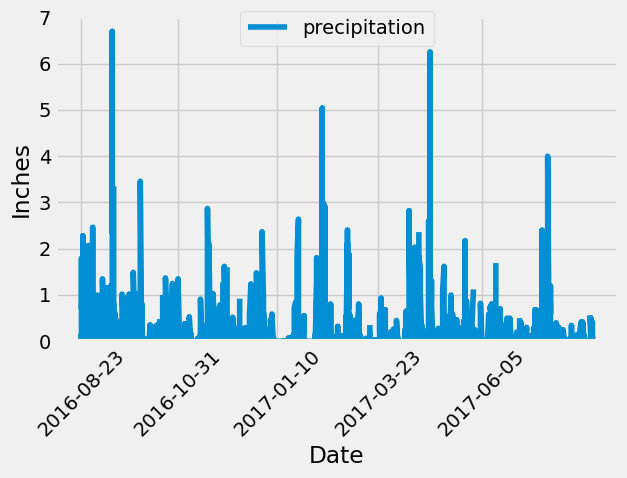

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(func.max(Measurement.date)).first()[0]
recent_date_dt = datetime.strptime(recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date_dt - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d'))\
    .order_by(Measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df = precipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6.5, 5))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.ylim(0, 7)
plt.xticks(precipitation_df['date'][::int(len(precipitation_df) / 5)], rotation=45)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=1)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = precipitation_df['precipitation'].describe()
summary_df = summary.to_frame('precipitation')
summary_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).all()
total_stations

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.id).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.most_active_station_id = most_active_stations[0][0]
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

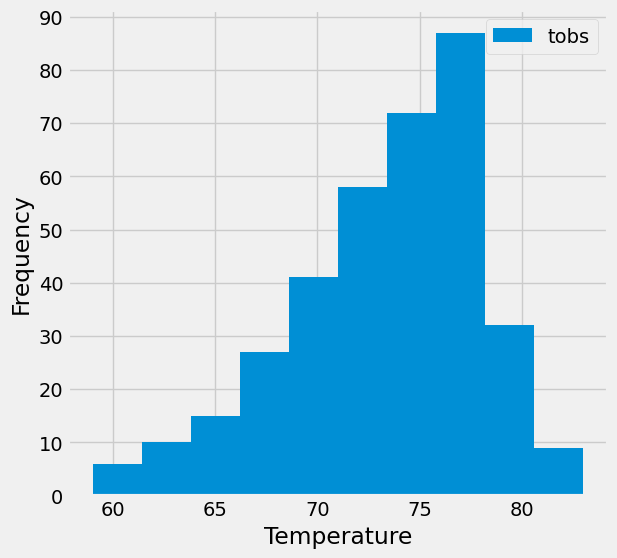

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_stations[0][0]
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)
last_12_months_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_ago.strftime('%Y-%m-%d')
).all()
temperatures = [temp[0] for temp in last_12_months_data]

plt.figure(figsize=(6.2, 6))
plt.hist(temperatures, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
max_y_value = int(max(plt.gca().get_ylim()))
plt.yticks(range(0, max_y_value, 10))
plt.legend()
plt.grid(True)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()